In [1]:
# reload notebook automatically after changes to source python files
%load_ext autoreload
%autoreload 2

# change base folder to parent
import os
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')
print(os.getcwd())

import torch
torch.hub.set_dir('/scratch/toponav/indoor-topo-loc/checkpoints/torchhub')
print(torch.hub.get_dir())  

/home2/rjayanti/workdirs/rjayanti/kp2seg-evals
/scratch/toponav/indoor-topo-loc/checkpoints/torchhub


In [2]:
from pathlib import Path
from configs.default import cfg
# from src.utils.viz_utils import load_image, plot_images

import sys

sys.path.insert(0, "/home2/rjayanti/workdirs/rjayanti/image-matching-models")


eval_spp_config = 'configs/config_eval_spp_resz.yaml'
cfg.merge_from_file(eval_spp_config)

CURR_SCENE='e8e81396b6'
# FRAME0_NAME, FRAME1_NAME = 'DSC05283', 'DSC05285' # 0-45
# FRAME0_NAME, FRAME1_NAME = 'DSC05283', 'DSC05181' # 45-90
# FRAME0_NAME, FRAME1_NAME = 'DSC05283', 'DSC05222' # 90-135
FRAME0_NAME, FRAME1_NAME = 'DSC05283', 'DSC05214' # 135-180

dslr_path = Path(cfg["DATASET"]["DATA_ROOT"])
segdata_orig_path = Path(cfg["DATASET"]["SEGDATA_ROOT"])

# load frames
frame0_path = dslr_path / CURR_SCENE / f"{FRAME0_NAME}.JPG"
frame1_path = dslr_path / CURR_SCENE / f"{FRAME1_NAME}.JPG"

frame0_segdata_path = segdata_orig_path / CURR_SCENE / f"{FRAME0_NAME}.JPG.pkl"
frame1_segdata_path = segdata_orig_path / CURR_SCENE / f"{FRAME1_NAME}.JPG.pkl"

In [3]:
from src.datasets.paired_data_interface import PairedImageMaskDataset
from torch.utils.data import DataLoader

img_paths0 = [frame0_path]
img_paths1 = [frame1_path]
mask_paths0 = [frame0_segdata_path]
mask_paths1 = [frame1_segdata_path]

dataset = PairedImageMaskDataset(
    img_paths0=img_paths0,
    img_paths1=img_paths1,
    mask_paths0=mask_paths0,
    mask_paths1=mask_paths1,
)

# NOTE: Currently dataset only supports batch size of 1 - to allow for variable number of masks
loader = DataLoader(dataset, batch_size=1)

In [4]:
from matching import get_matcher
from matching.viz import plot_matches

device = 'cuda'  # 'cpu'
matcher = get_matcher('mast3r', device=device, max_num_keypoints=4096)

batch = next(iter(loader))
img0_path, img1_path = batch['img0_path'], batch['img1_path']
masks0, masks1 = batch['masks0'], batch['masks1']

img0 = matcher.load_image(str(img0_path[0]))
img1 = matcher.load_image(str(img1_path[0]))

result = matcher(img0, img1)

/home2/rjayanti/workdirs/rjayanti/image-matching-models/matching/third_party/LightGlue/lightglue/lightglue.py:24: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
/home2/rjayanti/miniconda3/envs/mast3r/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home2/rjayanti/workdirs/rjayanti/image-matching-models/matching/third_party/mast3r/mast3r/model.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untr

TypeError: object of type 'NoneType' has no len()

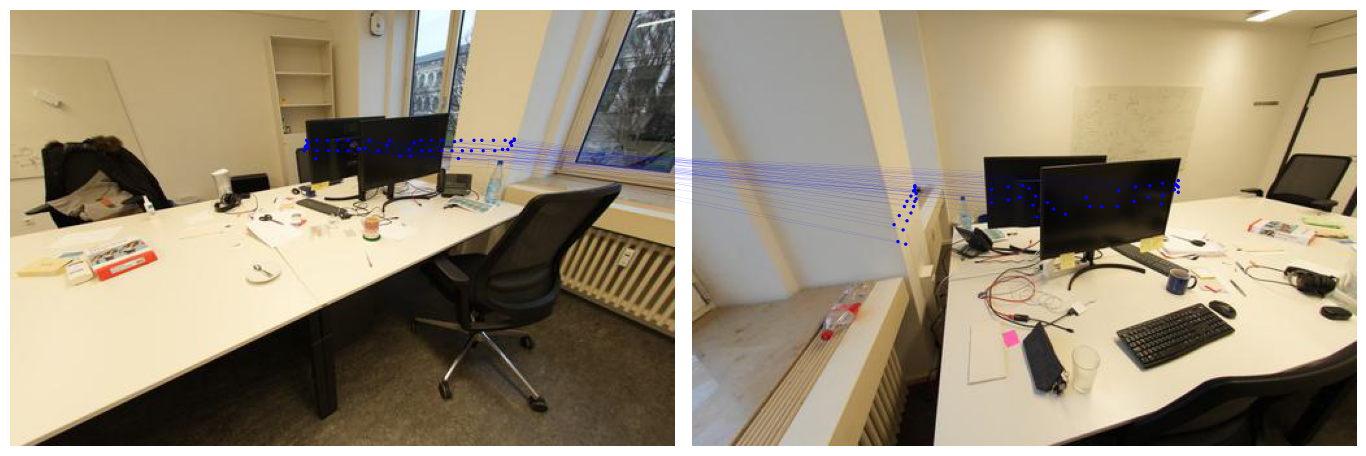

In [5]:
# num_inliers, inlier_kpts0, inlier_kpts1 = result['num_inliers'], result['inlier_kpts0'], result['inlier_kpts1']
# # result.keys() = ['num_inliers', 'H', 'all_kpts0', 'all_kpts1', 'all_desc0', 'all_desc1', 'matched_kpts0', 'matched_kpts1', 'inlier_kpts0', 'inlier_kpts1']
# make inlier_kpts0 and inlier_kpts1 None
result1 = result.copy()
result1["matched_kpts0"] = result['matched_kpts0'][-600:-550]
result1["matched_kpts1"] = result['matched_kpts1'][-600:-550]
result1['inlier_kpts0'] = None
result1['inlier_kpts1'] = None
plot_matches(img0, img1, result1, show_all_kpts=True)
all_kpts0, all_kpts1 = result1['all_kpts0'], result1['all_kpts1']
print(all_kpts0.shape, all_kpts1.shape)